## import

In [1]:
#importing libraries & packages

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import datetime
import re
import pprint
pp = pprint.PrettyPrinter(indent=4)
from collections import Counter
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
raw_df = pd.read_csv('Animal_Control_Incidents.csv')

In [3]:
#preserving original df before making alterations
df = raw_df.copy()

## functions

In [4]:
def comp_counts(cols, labels):
    sns.set(rc={'figure.figsize':(10, 5)})
    plt.xlim(-5,100)
    plt.title("times")
    for col, label in zip(cols, labels):
        print(df[col].value_counts())
        sns.distplot(df[col].value_counts(), label=label, bins=40)
    plt.legend()
    plt.show();

In [5]:
def plot_counts(cols):
    for i, col in enumerate(cols):
        plt.figure(i)
        sns.countplot(y=col, data=df);

In [63]:
def edit_replace(old_words, replacement_word):
# #     for old_word in old_words:
# #         try:
# #            data = data.apply(lambda x: x.astype(str).str.replace(old_word, replacement_word))
#         for old_word in old_words:
#            data = data.apply(lambda x: x.replace(old_word, replacement_word))
            
# #        except:
# #            data = data.str.replace(old_word, replacement_word)
    for word in old_words:
        df['color'] = df.color.apply(lambda x: x.replace(word, replacement_word))

In [7]:
def replace_breed(old_words, replacement_word):
    for word in old_words:
        df['breed'] = df.breed.apply(lambda x: x.replace(word, replacement_word))
        #for word in old_words:
          #  data = data.apply(lambda x: x.replace(word, replacement_word))

In [8]:
# seaborn correlation plot for categorical data
def corr_plot(data, minv=-.3, maxv=.3):
    
    #increased minv and/or maxv if too monochromatic
    
    # dummy categorical features
    col_list = list(data.select_dtypes(include=['object']).columns)

    # create dummies for categorical features
    data = pd.DataFrame(pd.get_dummies(data=data,columns=col_list
                       , prefix=col_list))
    sns.set(style="white")
    corr = data.corr()

    # mask the size of covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(10, 10))

    sns.heatmap(corr, mask=mask
                ,annot=False, cmap="YlGnBu", vmin = minv, vmax=maxv, center=0,
                square=True, linewidths=.5,cbar_kws= {"shrink": .5} );
    ax.invert_yaxis();
    
    #prevent the shrink of bottom row
    ax.set_ylim(len(data.columns), 0)

## cleaning/EDA

In [9]:
df.head()

,FILE NUMBER,INCIDENT DATE,INCIDENT TIME,DISPATCHED TIME,CALL TAKER,DISPATCHER,DISPATCHED OTHER,DISPATCHED SITUATION,ARRIVAL TIME,AVAILABLE TIME,...,CONDITION,TEMPERMENT,COLLAR,COLLAR COLOR,VACCINATION NUMBER,VACCINATION DATE,PET NAME,DISPOSITION,DISPOSITION DATE,DISPOSITION OFFICER
0,201639027,12/27/2016,15:30,16:06,UNKNOWN,JENNIFER G,0,D,16:17,16:38,...,FAIR,FRIENDLY,NYLON,RED,NaN,NaN,NaN,TRANS CAA,12/27/2016,FRANK S
1,201639044,12/28/2016,10:06,10:07,UNKNOWN,JENNIFER G,0,D,10:15,10:23,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,RETURN TO WILD,12/28/2016,TRAVIS R
2,201639036,12/28/2016,09:03,09:03,UNKNOWN,JENNIFER G,0,D,09:27,09:45,...,EMACIATED,FRIENDLY,LEATHER,PINK,NaN,NaN,NaN,TRANS CAA,12/28/2016,ISAAC S
3,201639042,12/28/2016,09:46,10:24,UNKNOWN,JENNIFER G,0,D,10:35,10:47,...,EMACIATED,FRIENDLY,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,JOHN B
4,201639059,12/28/2016,15:05,15:45,UNKNOWN,JENNIFER G,0,D,16:07,16:25,...,EMACIATED,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,SUE H


In [22]:
# removing spaces and lower casing the column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')

### datetime conversion

exclude last 30 days?
rec

In [11]:
time_cols= [col for col in df.columns if 'TIME' in col]

In [12]:
for col in time_cols:
    print(df[col].head())

In [13]:
for col in time_cols:
    #df[col] = df[col].dropna()
    df[col] = pd.to_datetime(df[col], format="%H:%M")

In [14]:
date_cols= [col for col in df.columns if 'DATE' in col]

In [15]:
for col in date_cols:
    print(df[col].head())

In [16]:
for col in date_cols:
    #df[col] = df[col].dropna()
    df[col] = pd.to_datetime(df[col], format="%m/%d/%Y")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73303 entries, 0 to 73302
Data columns (total 38 columns):
file number             73303 non-null int64
incident date           73303 non-null object
incident time           72818 non-null object
dispatched time         62547 non-null object
call taker              53134 non-null object
dispatcher              60239 non-null object
dispatched other        73303 non-null int64
dispatched situation    62537 non-null object
arrival time            61843 non-null object
available time          62545 non-null object
complainant street      73281 non-null object
request type            40141 non-null object
officer                 61235 non-null object
equipment number        60251 non-null object
remarks                 2098 non-null object
impound number          53110 non-null float64
impound date            53105 non-null object
impound time            53046 non-null object
location                52867 non-null object
municipality       

In [18]:
pandas_profiling.ProfileReport(df)

Number of variables,38
Number of observations,73303
Total Missing (%),34.8%
Total size in memory,21.3 MiB
Average record size in memory,304.0 B
Numeric,4
Categorical,33
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [19]:
# observations from pandas profile report:

# - lots of columns missing data

# irrelevant columns:
# - ARRIVAL TIME- has most at 00:00
# - AVAILABLE TIME- most at 00:00
# - CALL TAKER
# - COLLAR
# - COLLAR COLOR
# - IMPOUND NUMBER
# - INCIDENT TIME
# - PET NAME
# - REMARKS(too little data provided(3%), existing data doesn't appear to be useful)
# - VACCINATION DATE(99.5% missing)
# - VACCINATION NUMBER
# - ZIP CODE


# columns needing work or consider exclusion:
# - AGE 55% missing
# - X in front of BREED- cross breed?
# - CONDITION 31% missing
# - DISPATCHED OTHER and DISPATCHED SITUATION- what does it mean?
# - EQUIPMENT NUMBER - what does it mean?
# - FILE NUMBER - not unique, is referring to same animal?
# - REQUEST TYPE and SERVICE CODE appear to provide same content
# - SEX contains only 37% M or F, other data missing or irregular
# - SIZE 30% missing
# - SPECIES 28% missing
# - TEMPERMENT 30% missing
# - COLOR 29% missing
# - LOCATION and COMPLAINT STREET can be merged?


In [20]:
df.drop_duplicates(keep=False, inplace=True)

In [23]:
# creating column that fills in missing values from service code using existing values from request type
df['service_type']=df['service_code'].mask(pd.isnull, df['request_type'])

In [24]:
# dropping unneeded columns
df.drop(columns=['file_number', 'service_code', 'request_type'], inplace=True)

In [25]:
# creating day of week column:
df['weekday'] = pd.to_datetime(df['incident_date']).apply(lambda x: x.weekday())

In [26]:
df.weekday.value_counts()
# monday=0

0    16013
1    14086
2    13554
3    13131
4    12048
5     2232
6     1860
Name: weekday, dtype: int64

### missing data & exclusion

In [27]:
# preserving data to include na data
pre_drop_df= df.copy()
pre_drop_df = pre_drop_df.apply(lambda x: x.astype(str).str.lower())
pre_drop_df = pre_drop_df.apply(lambda x: x.astype(str).str.strip())
pre_drop_df = pre_drop_df.apply(lambda x: x.astype(str).str.replace(' ', '_'))

In [28]:
#percent missing values per column
round(df.isna().sum()/len(df)*100)

incident_date             0.0
incident_time             1.0
dispatched_time          14.0
call_taker               27.0
dispatcher               18.0
dispatched_other          0.0
dispatched_situation     14.0
arrival_time             15.0
available_time           14.0
complainant_street        0.0
officer                  17.0
equipment_number         18.0
remarks                  97.0
impound_number           28.0
impound_date             28.0
impound_time             28.0
location                 28.0
municipality             28.0
zip_code                 67.0
species                  28.0
breed                    29.0
sex                      45.0
size                     29.0
color                    30.0
age                      55.0
condition                31.0
temperment               30.0
collar                   66.0
collar_color             66.0
vaccination_number       99.0
vaccination_date        100.0
pet_name                 99.0
disposition              28.0
dispositio

In [29]:
# removing columns with more than 1/3 missing data
df.dropna(axis=1, thresh=(len(df)//1.5), inplace=True)

In [30]:
# check diff in value counts if dropna

# col_list = df.columns

# color_value_counts = df.color.value_counts()
# na_drop_color = (df.color.dropna()).value_counts()

## check difference of value counts if dropping all rows with nas:


# for column in col_list:
#    print (df[column].value_counts()/((df[column].dropna()).value_counts()))

In [31]:
#df = df.dropna(axis=0)

In [32]:
df = df.apply(lambda x: x.astype(str).str.lower())
df = df.apply(lambda x: x.astype(str).str.strip())
df = df.apply(lambda x: x.astype(str).str.replace(' ', '_'))

In [33]:
df.shape

(72924, 37)

### datetime features

#### times

In [34]:
time_cols= [col for col in df.columns if 'time' in col]
time_cols

['incident_time',
 'dispatched_time',
 'arrival_time',
 'available_time',
 'impound_time']

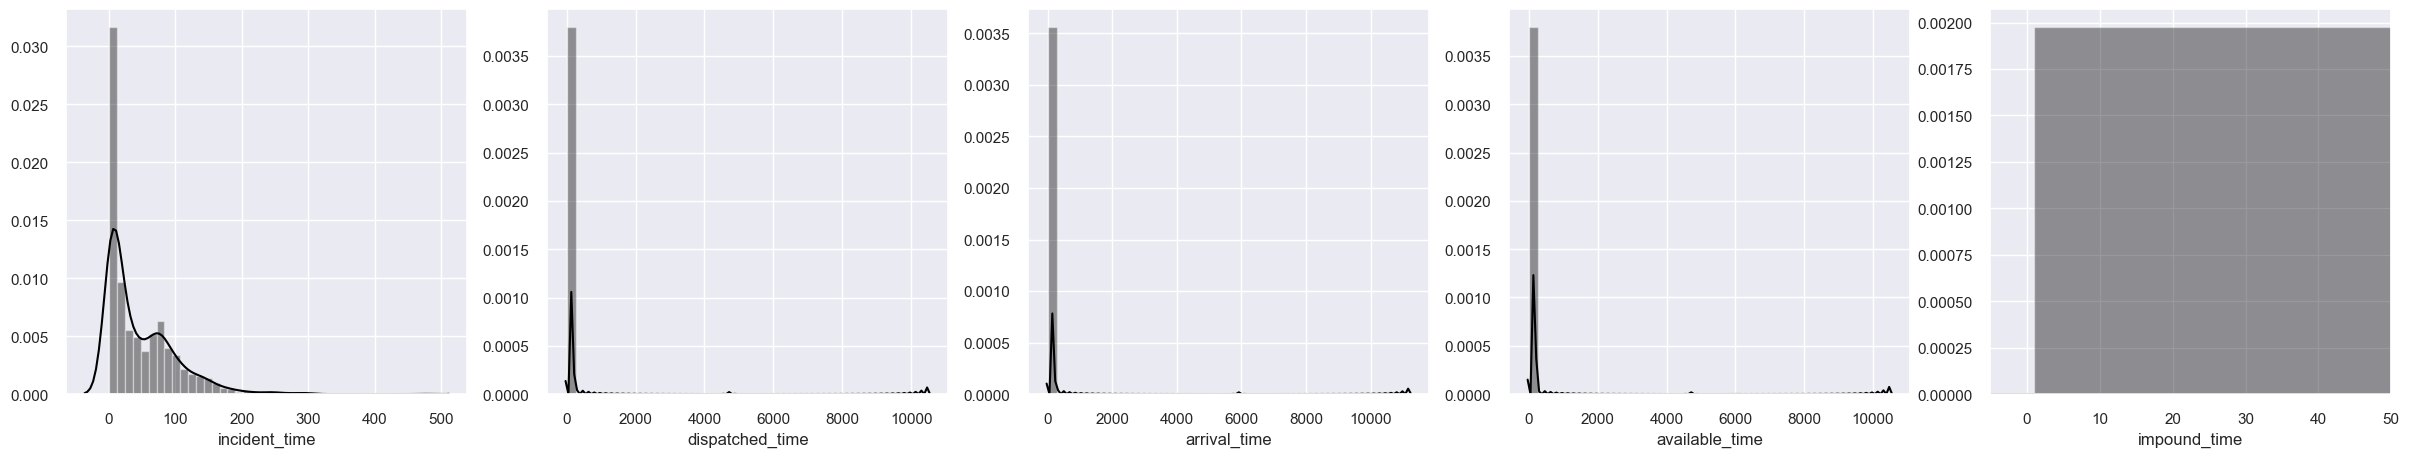

In [35]:
#comparing distribution of time features
#comp_counts(time_cols, time_cols)

sns.set(font_scale=1)

f, axes = plt.subplots(1, 5,figsize=(30,5))
plt.xlim(-5,50)
sns.distplot(df['incident_time'].value_counts(), ax=axes[0], color='black', bins=40)

sns.distplot(df['dispatched_time'].value_counts(), ax=axes[1], color='black',bins=40)

sns.distplot(df['arrival_time'].value_counts(), ax=axes[2], color='black', bins=40)

sns.distplot(df['available_time'].value_counts(), ax=axes[3], color='black', bins=40)

sns.distplot(df['impound_time'].value_counts(), ax=axes[4], color='black', bins=40);

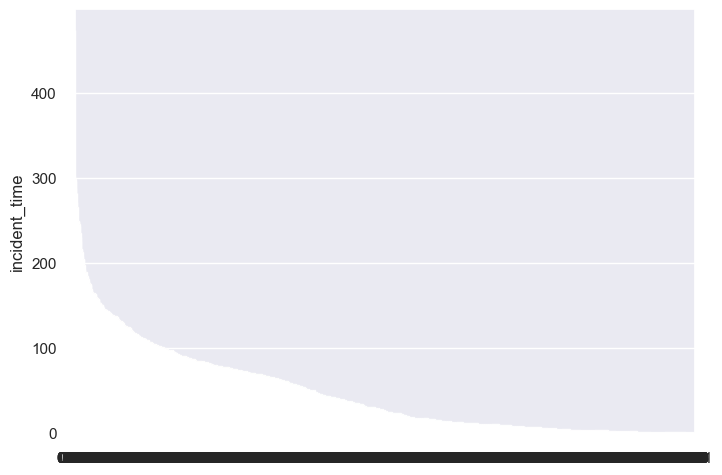

In [36]:
#sns.barplot(x = 'incident_time', y = df['incident_time'].value_counts().values, data = df, ci = None)
sns.barplot(x=df.incident_time.value_counts().index, y=df.incident_time.value_counts())

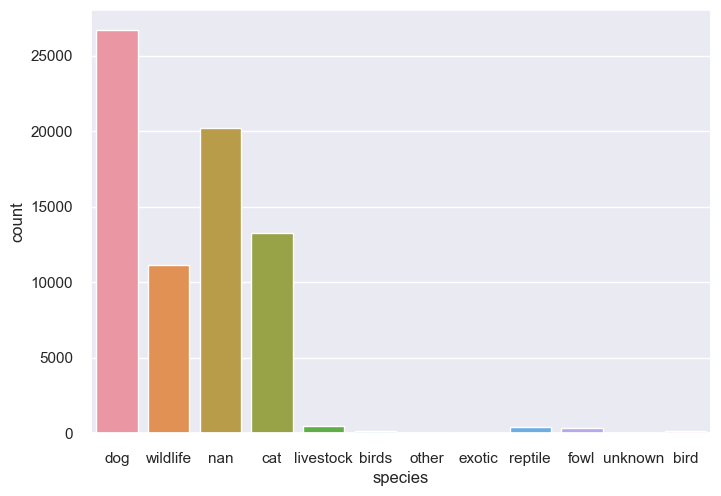

In [37]:
sns.countplot(x='species', data=df);

#### dates

In [38]:
date_cols= [col for col in df.columns if 'date' in col]
date_cols

['incident_date', 'impound_date', 'vaccination_date', 'disposition_date']

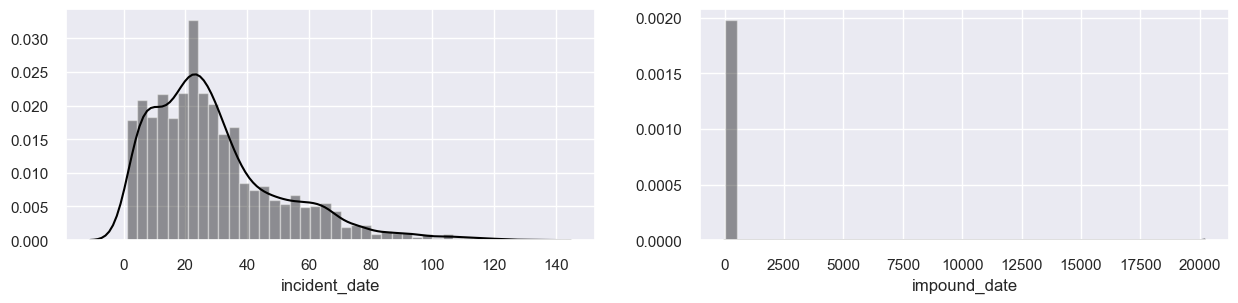

In [39]:
#comparing distribution of date features
#comp_counts(date_cols, date_cols)

sns.set(font_scale=1)

f, axes = plt.subplots(1, 2,figsize=(15,3))
sns.distplot(df['incident_date'].value_counts(), ax=axes[0], color='black', bins=40)
sns.distplot(df['impound_date'].value_counts(), ax=axes[1], color='black', bins=40);
#sns.distplot(df['disposition_date'].value_counts(), ax=axes[2], color='black', bins=40);

### names

In [40]:
name_cols = ('call_taker', 'dispatcher', 'officer', 'disposition_officer') 

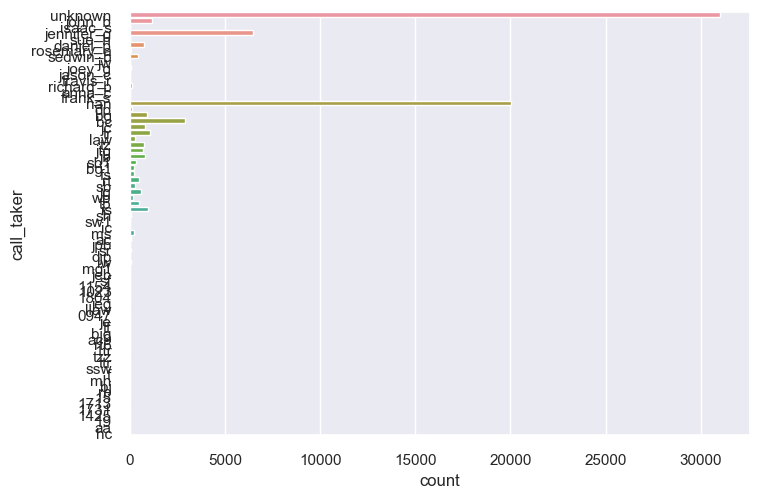

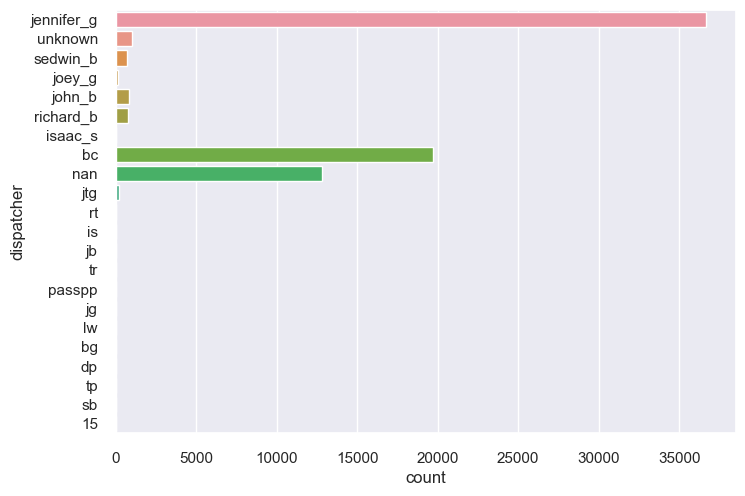

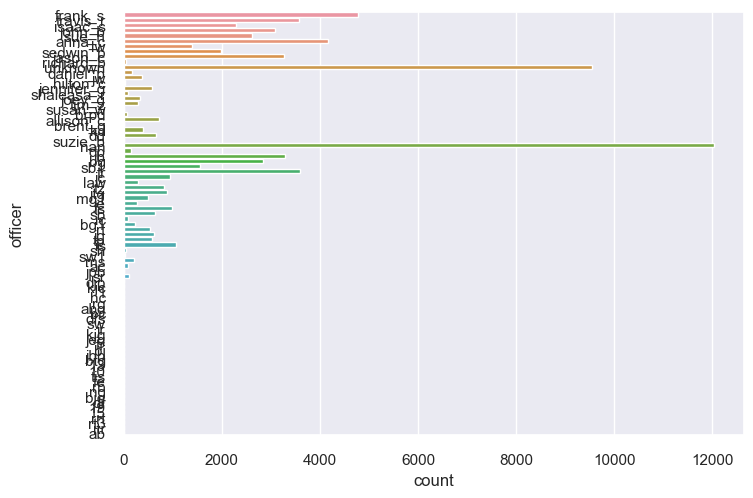

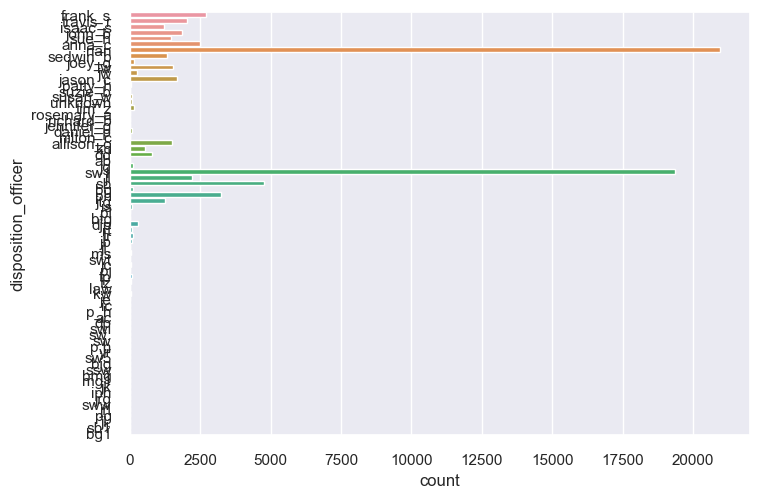

In [41]:
plot_counts(name_cols)

### location related

In [42]:
loc_cols = ('complainant_street', 'municipality', 'location')

### animal features

#### color

In [65]:
#df.color.value_counts()
df.color.value_counts()

nan                  21539
blk,wht               4373
blk                   4063
gry                   3222
gry,wht               1754
tan,wht               1653
brwn,wht              1603
blk,tan               1469
tan                   1430
brwn                  1421
gry,blk               1117
gray                  1087
brown                 1055
grey                   944
blk,gry                936
wht                    917
brn,blk                841
wht,blk                836
blk,brwn               762
brwn,blk               757
black                  722
org                    720
wht,brwn               633
brindle                597
wht,tan                582
tan,blk                569
brn                    550
wht,gry                454
brn,wht                409
brindle,wht            398
                     ...  
bray,brn                 1
blk,org,brwn,grn         1
brown,white,tabby        1
mallard                  1
blk,tanwht               1
no,hair                  1
b

Color Feature Cleaning:

- Not liking the all caps, also unnecessary punctuation.


- 1089 unique color values is going to be a problem for machine learning models, so I'd also like to reduce those. Each color needs to have uniform spelling, and combinations with low value counts will be categorized as 'other' to reduce dimensionality and noise.

*_I'll be treating each combination as it's own category. I'm not sure if approaching each color as a separate feature would be practical, but maybe could be given more thought later. I don't see value in each individual color as much as the overall description of color(s) as a whole._

In [64]:
characters = ('_','/', '.', '//','\\', ',,', ',,,', '_/_')

edit_replace(characters, ',')

In [66]:
# looking at strings separated to evaluate how to edit; priority in high value counts

results = Counter()
df['color'].str.split(',').apply(results.update)
pp.pprint (results)

Counter({   'nan': 21539,
            'blk': 20335,
            'wht': 18510,
            'gry': 9314,
            'tan': 8546,
            'brwn': 6961,
            'brn': 3136,
            'gray': 2395,
            'white': 2295,
            'grey': 2055,
            'brown': 1983,
            'black': 1871,
            'org': 1496,
            'brindle': 1404,
            'red': 792,
            'yellow': 626,
            'blue': 590,
            'gold': 446,
            'normal': 383,
            'tabby': 364,
            'orange': 285,
            'calico': 251,
            'torti': 221,
            '': 185,
            'cream': 171,
            'tri': 126,
            'beige': 119,
            'choc': 112,
            'chocolate': 102,
            'green': 92,
            'multi': 92,
            'blonde': 88,
            'fawn': 67,
            'golden': 67,
            'spots': 66,
            'wh': 58,
            'chest': 57,
            'w': 56,
            'pink': 50,
     

In [67]:
#white: wht
whites = ('white', 'cream', 'whute', 'whit', 'whitg', 'wht','whtie', 'wwht', 'what')

edit_replace(whites, 'wht')

In [68]:
# blacks: bl
blacks = ('black', 'blk', 'blkl', 'charcoal', 'bllk', 'balck', 'blavk', 'bkl', 'vlack', 'blavck', 'blkc')

edit_replace(blacks, 'bk')

In [69]:
#browns: br
browns = ('brown', 'brwn', 'brn', 'choc', 'chocolate', 'brwon', 'choclate', 'brw', 'brownish', 'brow', 'brnlate', 'brnish', 'brnolate', 'brnm', 'brolate', 'brblk','chestnut', 'cho', 'brrwn')

edit_replace(browns,'br')

In [70]:
#greys: gry
greys = ('grey', 'gray', 'grrey', 'grey', 'gry')

edit_replace(greys, 'gry')

In [71]:
# tans/beige/blonde: tn
tans = ('beige', 'blonde', 'golden', 'tan\\', 'goldish', 'tna', 'gold', 'tan', 'taan', 'sandy')

edit_replace(tans, 'tn')

In [72]:
# stripes: stripe_tabby
tabbies = ('tabby','tiger', 'tabble', 'taddy', 'tabs', 'tabbie')

edit_replace(tabbies, 'tab')

In [73]:
# striped: strip
# edit_replace(('stripe'), 'strip')

In [74]:
#orange: or
oranges = ('orange','org', 'orn', 'copper', 'orang', 'orage')

edit_replace(oranges, 'or')

In [75]:
#brindle/fawn: brndl
brindles = ('brindle', 'fawn', 'merle', 'torti', 'marbled', 'tortie', 'bridle', 'brndl', 'brndle', 'brndlee','leopard', 'tortoise', 'brindlw', 'brindlde')

edit_replace(brindles, 'bndle')

In [76]:
#yellow: ylw
edit_replace(('yellow','yelow','yellw', 'yell'), 'ylw')

In [77]:
# stop words and not decribing color
to_drop = (',chest','and', 'normal')

edit_replace(to_drop, '')

In [78]:
# other and unknown in nan category
unknowns = ('other', 'unknown')

edit_replace(unknowns, 'nan')

In [79]:
#limiting colors to selected and also only with certain value count(no longer using this method)

#colors = ('wht', 'bk', 'gry', 'br', 'tn', 'spot', 'or', 'tab', 'blue', 'red', 'ylw', 'calico', 'tri', 'green', 'multi', 'dark', 'light', 'pink')

#ndf = df[~df['color'].isin([colors])]

#ndf = ndf[ndf.color.value_counts()>=20]

#ndf.color.value_counts()

In [80]:
# defining counts to separate at 20 value counts
counts = df['color'].value_counts()

In [81]:
# color combinations with less than 20 counts will be categorized as 'other'
other_color_df =df[df['color'].isin(counts[counts < 20].index)]

other_color_df['color'] = 'other'

/Users/Janelle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [82]:
#should be one value: 'other'
other_color_df.color.value_counts()

other    2423
Name: color, dtype: int64

In [83]:
# color values with over/equal to n counts
colors_df =df[df['color'].isin(counts[counts >= 20].index)]

In [84]:
#should be n or more per value
colors_df.color.value_counts().tail()

br,red        21
gry,tn,bk     20
bk,gry,tab    20
bk,green      20
pink          20
Name: color, dtype: int64

In [85]:
#joining the 'other color' and 'all colors' dfs
ec_df = pd.concat([colors_df,other_color_df ])
len(ec_df)

72924

In [86]:
#all should have a minimum n value counts, 'other' should now be included
ec_df.color.value_counts()

nan           21582
gry            5253
bk,wht         4798
bk             4796
br             3147
other          2423
br,wht         2403
gry,wht        2284
tn,wht         1987
br,bk          1739
tn             1718
bk,tn          1691
gry,bk         1614
wht            1395
bk,gry         1305
bk,br          1130
wht,bk          907
wht,br          903
bndle           850
or              833
wht,tn          682
tn,bk           620
wht,gry         586
bndle,wht       509
gry,tn          493
or,wht          445
ylw             387
bk,br,wht       384
                383
gry,br          339
              ...  
br,tn,wht        51
br,tab           50
wht,tn,bk        47
bk,gry,tn        46
br,,bk           44
or,tab           37
br,ylw           33
or,bk            32
bk,tn,gry        30
gry,wht,bk       28
bk,red           28
gry,or           27
red,br           27
gry,pink         26
tn,gry,wht       26
green            25
gry,wht,tn       25
wht,or,bk        24
wht,bk,gry       24


In [87]:
# quick check that all rows are still there
len(ec_df)

72924

In [ ]:
# results = Counter()
# df['color'].str.split(',').apply(results.update)
# pp.pprint (results)

#### breed

In [88]:
df.breed.value_counts()

nan                               21018
dsh                               11494
possum                             5447
pitbull                            5445
raccoon                            4370
xpit_bull                          4276
xlabrador                          2846
xterrier                           1394
xshepherd                           951
pit                                 925
labrador_retriever                  918
dmh                                 831
german_shepherd                     792
terrier                             770
dlh                                 712
xgerman_shepherd                    621
xhound                              547
chihuahua                           451
squirrel                            406
xchihuahua                          381
horse                               352
other                               334
shih_tzu                            316
xrottweiler                         307
rottweiller                         298


In [89]:
# removing x. This could mean cross breed, but for the sake of dimension reducing, will be removed.
# may find it more beneficial to not remove in future work?

df['breed'] = df.breed.apply(lambda x: x.replace('x', ''))

In [124]:
sorted_breeds=df.sort_values('breed')
sorted_breeds.breed.unique()

array(['akita', 'alaskan__malamute', 'american_bulldog',
       'american_eskimo', 'american_staffordshire_terrier', 'armadillo',
       'australian_blue_healer', 'australian_cattle',
       'australian_shepherd', 'basenji', 'basset', 'bat', 'beagle',
       'beaver', 'bichons_frise', 'bloodhound', 'bluetick_hound', 'boer',
       'border_collie', 'boston', 'bourvier_des_flanders', 'brittany',
       'brittany_spaniel', 'bull_mastiff', 'bull_terrier',
       'bulldog_(french)', 'bulldog_english', 'cairn_terrier',
       'cane_corso', 'catahoula', 'chicken', 'chihuahua', 'chinchilla',
       'chow', 'cocker_spaniel', 'collie', 'coonhound', 'cow', 'coyote',
       'crow', 'curr', 'dachshund', 'dalmation', 'dlh', 'dmh', 'doberman',
       'doberman_pinscher', 'donkey', 'dsh', 'duck_domestic', 'ferret',
       'fish', 'fo_terrier', 'fohound', 'german_shepherd', 'goat',
       'golden_retriever', 'goose', 'great_dane', 'great_pyrenees',
       'greyhound', 'guinea', 'guinea_pig', 'hamster',

In [125]:
#replacing alternate spellings of same breed
df = df.apply(lambda x: x.replace(' ', '_'))
df = df.apply(lambda x: x.replace('bulldog_(english)', 'bulldog_english'))
df = df.apply(lambda x: x.replace('chow_chow', 'chow'))
df = df.apply(lambda x: x.replace('boston_terrier', 'boston'))
df = df.apply(lambda x: x.replace('poodle_-standard', 'poodle'))
df = df.apply(lambda x: x.replace('basset_hound', 'basset'))
df = df.apply(lambda x: x.replace('rottweiller', 'rott'))
df = df.apply(lambda x: x.replace('rottweiler', 'rott'))
df = df.apply(lambda x: x.replace('pit_bull', 'pitbull'))
df = df.apply(lambda x: x.replace('pitbull', 'pit'))
df = df.apply(lambda x: x.replace('_german_shepherd', 'german_shepherd'))
df = df.apply(lambda x: x.replace('_retriever', 'retriever'))
df = df.apply(lambda x: x.replace('labrador_retriever', 'labrador'))
df = df.apply(lambda x: x.replace('poodle_(min/toy)', 'poodle_min/toy'))
df = df.apply(lambda x: x.replace('poodle_standard', 'poodle'))
df = df.apply(lambda x: x.replace('catahoula_hound', 'catahoula'))
df = df.apply(lambda x: x.replace('english_bulldog', 'bulldog_english'))
df = df.apply(lambda x: x.replace('bulldog_(french)', 'bulldog_french'))
df = df.apply(lambda x: x.replace('boer', 'boxer'))
df = df.apply(lambda x: x.replace('fo_terrier', 'fox_terrier'))
df = df.apply(lambda x: x.replace('shar_pei', 'sharpei'))
df = df.apply(lambda x: x.replace('alaskan__malamute','alaskan_malamute'))
df = df.apply(lambda x: x.replace('brittany_spaniel', 'brittany'))
df = df.apply(lambda x: x.replace('fohound', 'foxhound'))
# def replace_breed(old, replaced, df=df):
#     df = df.apply(lambda x: x.replace(old,replaced))

# replace_breed('rottweiller', 'rottweiler')
# replace_breed('rotweiler', 'rott')
# replace_breed('pit_bull', 'pitbull')
# replace_breed('pitbull', 'pit')
# replace_breed('_german_shepherd', 'german_shepherd')
# replace_breed('labroador_retriever', 'labrador')
# replace_breed('poodle_(min/toy)', 'poodle_min/toy')
# replace_breed('poodle_standard', 'poodle')


In [126]:
#letter_count = collections.Counter("alphabet")
results = Counter()
df['breed'].str.split(',').apply(results.update)
pp.pprint (results)

Counter({   'nan': 21018,
            'dsh': 11494,
            'pit': 10646,
            'possum': 5447,
            'raccoon': 4370,
            'labrador': 3764,
            'terrier': 2164,
            'german_shepherd': 1567,
            'shepherd': 1042,
            'chihuahua': 832,
            'dmh': 831,
            'dlh': 712,
            'hound': 672,
            'rott': 605,
            'boer': 446,
            'squirrel': 406,
            'horse': 352,
            'beagle': 339,
            'other': 334,
            'catahoula': 325,
            'chow': 321,
            'shih_tzu': 316,
            'armadillo': 285,
            'dachshund': 251,
            'retriever': 240,
            'mied': 234,
            'husky': 194,
            'yorkshire_terrier': 180,
            'american_bulldog': 163,
            'bat': 159,
            'snake_domestic_non_poisonous': 158,
            'siamese': 146,
            'poodle': 138,
            'australian_shepherd': 137,
         

In [127]:
dogs = ('pit', 'labrador', 'terrier', 'german_shepherd', 'shepherd', 'chihuahua', 'hound', 'rott'
        , 'boxer', 'beagle', 'catahoula', 'chow', 'shih_tzu', 'dachshund', 'retriever', 'husky'
        , 'yorkshire_terrier', 'american_bulldog', 'poodle', 'australian_shepherd', 'poodle_min/toy'
        , 'collie', 'pomeranian', 'mastiff', 'golden_retriever', 'maltese', 'cocker_spaniel', 'healer'
        , 'doberman_pinscher', 'miniature_pinscher', 'border_collie', 'schnauzer', 'great_dane'
        , 'rat_terrier', 'akita', 'jack_russel_terrier', 'bulldog_english', 'spaniel', 'doberman'
        , 'pug', 'pekingese', 'basset', 'dalmation', 'boston', 'weimeraner', 'lhasa_apso', 'pointer'
        , 'rhodesian_ridgeback', 'sharpei', 'great_pyrenees', 'bull_terrier', 'bichons_frise', 'bloodhound'
        , 'saint_bernard', 'springer_spaniel', 'sheepdog', 'alaskan_malamute', 'scottish_terrier'
        , 'cairn_terrier', 'staffordshire_bull_terrier', 'setter', 'sheltie', 'cane_corso', 'whippet'
        ,  'basenji', 'spitz', 'greyhound', 'walker_hound', 'siberian_husky', 'west_highland_terrier'
        , 'american_eskimo', 'bull_mastiff', 'brittany', 'bluetick_hound', 'foxhound', 'australian_cattle'
        , 'american_staffordshire_terrier', 'bulldog_french', 'australian_blue_heeler', 'bourvier_des_flanders'
        , 'fox_terrier', 'wolf', 'coonhound', 'norweigian_elkhound')

#### condition, temperment, size

In [ ]:
#value counts of species, size, condition, and temperment features
ssct_df = df[['species', 'size', 'condition', 'temperment']]

In [ ]:
plot_counts(ssct_df)

In [ ]:
# correlations between species, size, condition, and temperment
corr_plot(ssct_df, -.3, .3)

#

In [ ]:
# drop rows with any unknowns
#df = df[~df.eq('unknown').any(1)]

In [ ]:
len(df)

In [ ]:
df.condition.value_counts()

In [ ]:
df.temperment.value_counts()

In [ ]:
df['size'].value_counts()

In [ ]:
#cts_df = df[['condition', 'temperment', 'size']]

#corr_plot(cts_df, -.3, .3)

### incident features

In [ ]:
df.service_type.value_counts()

In [ ]:
#df['service_type']=df['service_code'].mask(pd.isnull, df['request_type'])

In [ ]:
df['service_type'] = df['service_type'].apply(lambda x: x.replace('stray_an._secured', 'stray_an_secured'))
df['service_type'] = df['service_type'].apply(lambda x: x.replace('dangerous_animal_sit.', 'dangerous_animal_sit'))

#### equipment number

In [ ]:
df.equipment_number.value_counts()

In [ ]:
#df.groupby(['zip_code'])['municipality_'].value_counts().unstack().plot.bar(figsize=(14,7));